# MLE Portfolio Project - Customer Churn 

This project is to finish the course `Machine Learning/AI Engineer Career Path` on [CodeCademy](https://www.codecademy.com/) and to showcase what I have learned by implementing some concepts and creating clean and reproducible code.

Dataset: 
I took the data from [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download) and it is a dataset showing `Telco Customer Churn`. In the following project I will create machine learning pipelines to make out which models perform best and which features are most predictive of a customer churning.

This type of analysis could be of great help to businesses, as it attacks the problem of trend detection and future readiness.

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score,classification_report
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import time
from imblearn.over_sampling import SMOTE


Let's load and inspect the data!

In [177]:
churn_df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_columns', None)
churn_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


I see that I won't need the customerID column and I can convert the columns with Yes/No to contain 1/0 valueas.

In [178]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [179]:
#value counts for each column in one dictionary
value_counts = {}
for column in churn_df.columns:
    if churn_df[column].dtype == 'object' and column != 'customerID':
        value_counts[column] = churn_df[column].value_counts()
        print(value_counts[column])
        print('\n')



Male      3555
Female    3488
Name: gender, dtype: int64


No     3641
Yes    3402
Name: Partner, dtype: int64


No     4933
Yes    2110
Name: Dependents, dtype: int64


Yes    6361
No      682
Name: PhoneService, dtype: int64


No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64


Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64


No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64


No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64


No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64


No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64


No                     2810
Yes                    2707
No internet service    15

I see that TotalCharges has to be changed to numeric as it is a type "object". 

Let's actually do these changes!

In [180]:
df_churn = churn_df.drop(['customerID'], axis=1)
df_churn["Partner"] = df_churn["Partner"].map({"Yes": 1, "No": 0})
df_churn["Dependents"] = df_churn["Dependents"].map({"Yes": 1, "No": 0})
df_churn["PhoneService"] = df_churn["PhoneService"].map({"Yes": 1, "No": 0})
df_churn["PaperlessBilling"] = df_churn["PaperlessBilling"].map({"Yes": 1, "No": 0})
df_churn["Churn"] = df_churn["Churn"].map({"Yes": 1, "No": 0})

df_churn["TotalCharges"] = pd.to_numeric(df_churn["TotalCharges"], errors='coerce')

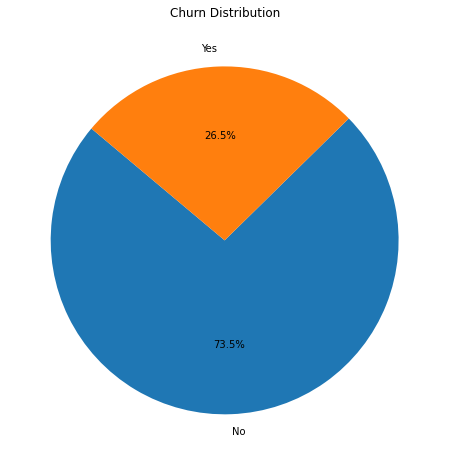

In [181]:
churn_counts = churn_df["Churn"].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Churn Distribution')
plt.show()

The sample is imbalanced and I will handle that with SMOTE, but first I will split the data into training and testing.

Nice! Now I can do the train-test split and the transformation of the TotalCharges column!

In [182]:
X = df_churn.drop(['Churn'], axis=1)
y = df_churn['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(y_train.value_counts())

0    4138
1    1496
Name: Churn, dtype: int64


I see that I have some categorical columns and some variables that are continuous, so I will create a pipeline for each.

In [183]:
# Preprocessing for numerical data
num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])
# Preprocessing for categorical data
cat_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(sparse = False, drop = "first", handle_unknown = "ignore"))])

# Bundle preprocessing for numerical and categorical data
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_cols),('cat', cat_transformer, cat_cols)])

With this ready, I am able to implement the models that I will be using for this project and tune the hyperparameters.

First I will check the accuracy of the pipeline for logistic regression without tuning.

In [184]:
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter = 1000))])

pipeline_lr.fit(X_train, y_train)
pipeline_test_score = pipeline_lr.score(X_test, y_test)
pipeline_train_score = pipeline_lr.score(X_train, y_train)
print("The pipeline train score is: ", pipeline_train_score)
print("The pipeline test score is: ", pipeline_test_score)
print("The model is: ", pipeline_lr.named_steps['classifier'].get_params())
print("The f1 score is: ", f1_score(y_test, pipeline_lr.predict(X_test)))

The pipeline train score is:  0.8033368832090877
The pipeline test score is:  0.8218594748048261
The model is:  {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
The f1 score is:  0.6409155937052933


Visualizing feature importance.

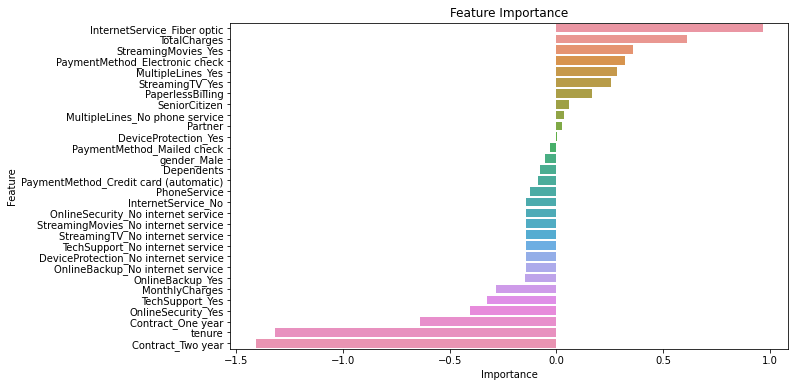

In [185]:
feature_importances = pipeline_lr.named_steps['classifier'].coef_[0]

# Assuming you have a list of original feature names
feature_names = pd.get_dummies(X_train, columns=cat_cols, drop_first=True).columns

# Create a DataFrame of feature importances
importances_df = pd.DataFrame(data={
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Feature Importance')
plt.show()


In [197]:
def parameter_finder (model, parameters):

    start = time.time()

    grid = GridSearchCV(model,
                        param_grid = parameters,
                        refit = True,
                        cv = KFold(shuffle = True, random_state = 1),
                        n_jobs = 1)
    grid_fit = grid.fit(X_train, y_train)
    best = grid_fit.best_estimator_
    y_pred = best.predict(X_test)

    train_score =best.score(X_train, y_train)
    test_score = best.score(X_test, y_test)
    F1_score = f1_score(y_test, y_pred).round(2)
    results = classification_report(y_test, y_pred)
    model_name = str(model).split('(')[0]

    end = time.time()
    takes_time = np.round(end - start,2)

    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"F1 score is {F1_score:,} for {model_name} model.")
    print("--" * 10)
    print(f"Runtime of the program is: {end - start:0.2f}")


    return best,train_score, test_score, F1_score, y_pred, takes_time, results

Now let the tuning commence!

In [198]:
logistic_regression_search = [
{
'classifier__penalty': ['l2', 'l1'],
'classifier__C': np.logspace(-2, 2, 20),
'classifier__solver': ['liblinear']
}
]
lr_model, train_lr, test_lr, f1_lr, pred_lr, time_lr, lr_results = parameter_finder(pipeline_lr, logistic_regression_search)
print(lr_results)

The best parameters for Pipeline model is: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
--------------------
(R2 score) in the training set is 79.96% for Pipeline model.
(R2 score) in the testing set is 82.04% for Pipeline model.
F1 score is 0.62 for Pipeline model.
--------------------
Runtime of the program is: 22.17
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.70      0.56      0.62       373

    accuracy                           0.82      1409
   macro avg       0.78      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409



In [199]:
rf_search_space=[{
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 3, 5, 12],
},]
rf_model, train_rf, test_rf, f1_rf, pred_rf, time_rf, rf_results = parameter_finder(pipeline_lr, rf_search_space)
print(rf_results)

The best parameters for Pipeline model is: {'classifier': RandomForestClassifier(max_depth=12, n_estimators=200), 'classifier__max_depth': 12, 'classifier__n_estimators': 200}
--------------------
(R2 score) in the training set is 92.72% for Pipeline model.
(R2 score) in the testing set is 80.70% for Pipeline model.
F1 score is 0.59 for Pipeline model.
--------------------
Runtime of the program is: 18.16
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.68      0.52      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



In [200]:
knn_search_space=[{
    'classifier': [KNeighborsClassifier()],
    'classifier__n_neighbors': [3, 5, 7, 9,11,13],
    'classifier__weights': ['uniform', 'distance'],
    "classifier__p": [1,2]
},]
knn_model, train_knn, test_knn, f1_knn, pred_knn, time_knn, knn_results = parameter_finder(pipeline_lr, knn_search_space)
print(knn_results)

The best parameters for Pipeline model is: {'classifier': KNeighborsClassifier(n_neighbors=13), 'classifier__n_neighbors': 13, 'classifier__p': 2, 'classifier__weights': 'uniform'}
--------------------
(R2 score) in the training set is 80.87% for Pipeline model.
(R2 score) in the testing set is 79.91% for Pipeline model.
F1 score is 0.6 for Pipeline model.
--------------------
Runtime of the program is: 14.35
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1036
           1       0.64      0.56      0.60       373

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



In [201]:
result = {
    "Train Score":[train_lr,train_knn,train_rf],
    "test Score":[test_lr,test_knn,test_rf],
    "F1 Score":[f1_lr,f1_knn,f1_rf]
}

index = np.array(["Logistic Reg","KNeighbors",
                  "Random Forest "])

res_df = pd.DataFrame(data=result,index=index)
res_df

,Train Score,test Score,F1 Score
Logistic Reg,0.799610,0.820440,0.62
KNeighbors,0.808662,0.799148,0.60
Random Forest,0.927228,0.806955,0.59


The best performing model from the onces I looked at is the Logistic Regression with a test score of 0.82.

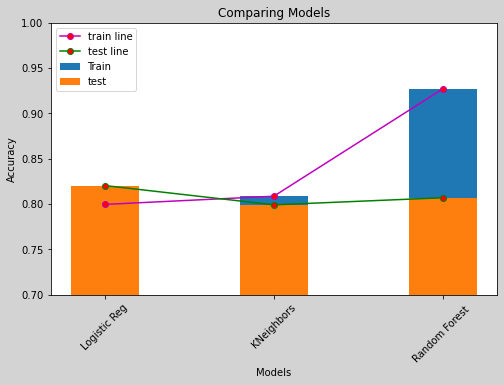

In [202]:
ig , ax = plt.subplots(figsize=(8,5),facecolor="lightgray")
x = np.arange(3)
ax.plot(x,res_df["Train Score"],marker="o",mfc="red",color="m",label="train line")
ax.bar(x,res_df["Train Score"],label="Train",width=0.4)
ax.plot(x,res_df["test Score"],marker="o",mfc="red",color="green",label="test line")
ax.bar(x,res_df["test Score"],label="test",width=0.4)
ax.set(xticks=x,ylim=[0.7,1],xlabel="Models",ylabel="Accuracy",
      title="Comparing Models")
ax.set_xticklabels(index,rotation=45)
ax.legend()